## Outlier Detection with One-Class SVMs

In [1]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [2]:
# define dataset
X, y = make_classification(n_samples=10000, 
                           n_features=2, 
                           n_redundant=0,
                           n_clusters_per_class=1, 
                           weights=[0.999], 
                           flip_y=0, 
                           random_state=4)

# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9990, 1: 10})


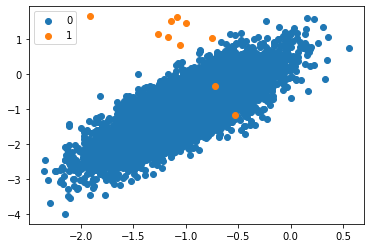

In [3]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    
pyplot.legend()
pyplot.show()

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM.

In [5]:
from sklearn.svm import OneClassSVM

In [6]:
# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)

The model can be fit on all examples in the training dataset or just those examples in the majority class.

we will try fitting on just those examples in the training set that belong to the majority class.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

In [11]:
# fit on majority class
trainX = trainX[trainy==0]
model.fit(trainX)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [12]:
# detect outliers in the test set
yhat = model.predict(testX)

In [13]:
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1

In [15]:
from sklearn.metrics import f1_score

In [16]:
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.123


## one-class SVM for novelty detection

In [30]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [31]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

In [32]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]

In [33]:
X_train[:5]

array([[1.72907406, 1.40597928],
       [2.25860049, 1.94643608],
       [2.68045577, 1.55712473],
       [2.37210621, 1.59803516],
       [1.576823  , 1.95324001]])

In [34]:
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

In [35]:
X_test[:5]

array([[1.50091734, 2.49504632],
       [1.41284916, 1.9973333 ],
       [2.26108003, 1.69052625],
       [1.82445255, 2.08597812],
       [2.06478952, 2.16567191]])

In [36]:
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X_outliers[:5]

array([[ 0.41756062, -3.49144352],
       [ 0.43649715, -3.73025832],
       [ 1.06291109, -1.24063379],
       [ 2.49293209, -2.97999854],
       [ 1.56436072, -0.76404883]])

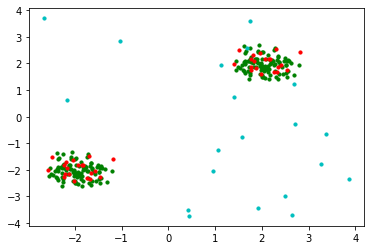

In [43]:
plt.scatter(X_train[:, 0], X_train[:, 1], c='g', s=10)
plt.scatter(X_test[:, 0],  X_test[:, 1],  c='r', s=10)
plt.scatter(X_outliers[:, 0],  X_outliers[:, 1],  c='c', s=10)

In [45]:
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [46]:
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

In [47]:
y_pred_train    = clf.predict(X_train)
y_pred_test     = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [49]:
n_error_train    = y_pred_train[y_pred_train == -1].size
n_error_test     = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [50]:
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

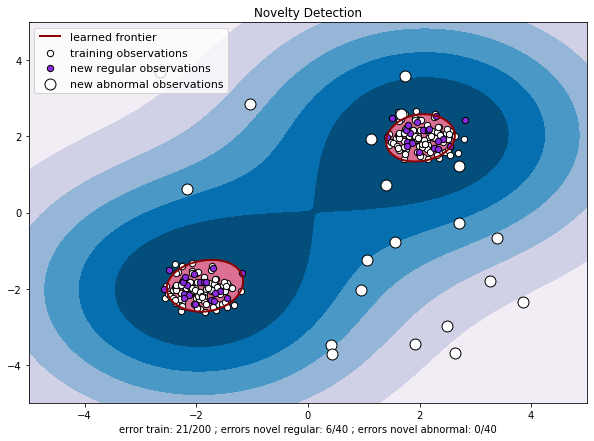

In [58]:
plt.figure(figsize=(10, 7))
plt.title("Novelty Detection")

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)

a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], 
                 X_train[:, 1], 
                 c='white', 
                 s=s, 
                 edgecolors='k')

b2 = plt.scatter(X_test[:, 0], 
                 X_test[:, 1], 
                 c='blueviolet', 
                 s=s,
                 edgecolors='k')

c = plt.scatter(X_outliers[:, 0], 
                X_outliers[:, 1], 
                c='w', 
                s=3*s,
                edgecolors='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))

plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers));